In [94]:
from influxdb_client import InfluxDBClient
import pandas as pd
import os
from IPython.display import Markdown
import warnings
import datetime
import matplotlib.pyplot as plt
import random
import numpy as np
warnings.filterwarnings("ignore")


## Connessione al database InfluxDB
INFLUXDB_URL = "http://localhost:8086"
TOKEN = os.getenv("token")  
ORG = "IotAlarmSystem"
BUCKET = "Prova"
client = InfluxDBClient(url=INFLUXDB_URL, token=TOKEN, org=ORG)
query_api = client.query_api()

## Query 
query = f"""
from(bucket: "{BUCKET}")
|> range(start: -7d)
|> filter(fn: (r) => r._measurement == "pressure")
|> filter(fn: (r) => r._field == "value")
|> keep(columns: ["_time", "_value"])
"""

result = query_api.query(query)
data = []


# Converti i risultati in un DataFrame
for table in result:
    for record in table.records:
        data.append({"time": record["_time"], "value": record["_value"]})
df = pd.DataFrame(data)

In [95]:
timestamps = []
values = []

for single_date in pd.date_range(start=start_date, end=end_date, freq="D"):
    sleep_start_hour = int(np.random.choice([21, 22, 23]))
    sleep_start_minute = random.randint(0, 59)

    wake_up_hour = int(np.random.choice([7, 8, 9]))
    wake_up_minute = random.randint(0, 59)

    night_start = datetime.datetime(single_date.year, single_date.month, single_date.day, sleep_start_hour, sleep_start_minute, 0, tzinfo=datetime.timezone.utc)
    night_end = night_start + datetime.timedelta(hours=(24 - sleep_start_hour))  

    morning_start = night_end
    next_day = pd.Timestamp(single_date) + pd.Timedelta(days=1)
    morning_end = datetime.datetime(next_day.year, next_day.month, next_day.day, wake_up_hour, wake_up_minute, 0, tzinfo=datetime.timezone.utc)

    timestamps.extend(pd.date_range(start=night_start, end=night_end, freq="1T", tz="UTC"))
    values.extend([4095] * len(pd.date_range(start=night_start, end=night_end, freq="1T", tz="UTC")))

    timestamps.extend(pd.date_range(start=morning_start, end=morning_end, freq="1T", tz="UTC"))
    values.extend([4095] * len(pd.date_range(start=morning_start, end=morning_end, freq="1T", tz="UTC")))

    day_start = morning_end
    next_night_start = datetime.datetime(next_day.year, next_day.month, next_day.day, 21, random.randint(0, 59), 0, tzinfo=datetime.timezone.utc)

    timestamps.extend(pd.date_range(start=day_start, end=next_night_start, freq="1T", tz="UTC"))
    values.extend([2000] * len(pd.date_range(start=day_start, end=next_night_start, freq="1T", tz="UTC")))

simulated_df_random = pd.DataFrame({"time": timestamps, "value": values})


In [96]:
def calculate_total_time(df, start_time=None, end_time=None):
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values("time")

    ## Conversione tempo 
    if start_time:
        start_time = pd.to_datetime(start_time).tz_localize("UTC")
        df = df[df['time'] >= start_time]

    if end_time:
        end_time = pd.to_datetime(end_time).tz_localize("UTC")
        df = df[df['time'] <= end_time]


        
    transitions = []
    indices_4095 = []


    # Calcolo il tempo "dormito" prendendo il primo 4095 e facendo la differenza con il prossimo != 4095
    i = 0
    while i < len(df):
        while i < len(df) and df.iloc[i]['value'] != 4095:
            i += 1
        if i >= len(df):
            break

        start_index = df.index[i]  
        start_time = df.iloc[i]['time']

        while i < len(df) and df.iloc[i]['value'] == 4095:
            i += 1
        if i >= len(df):
            break

        end_time = df.iloc[i]['time']
        time_diff = (end_time - start_time).total_seconds()
        transitions.append(round(time_diff, 2))
        indices_4095.append(start_index)
    total_seconds = sum(transitions)


    # Convertire in ore, minuti e secondi
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)

    return f"{hours} ore, {minutes} minuti e {seconds} secondi"

In [99]:
def calculate_corrected_sleep_per_night(df):
    """
    Calcola il tempo totale di sonno per ogni notte, considerando la notte dalle 21:00 del giorno X 
    alle 10:00 del giorno X+1 e ignorando i dati al di fuori di questo intervallo.
    """
    df["time"] = pd.to_datetime(df["time"])

    df["night"] = df["time"].dt.date
    df["hour"] = df["time"].dt.hour


    df.loc[df["hour"] < 10, "night"] = df["night"] - pd.Timedelta(days=1)
    df = df[(df["hour"] >= 21) | (df["hour"] < 10)]

    sleep_data = []

    # Raggruppare per ogni notte e fare il debug
    for night, night_df in df.groupby("night"):
        sleep_seconds = 0
        i = 0
        sleep_sessions = []

        while i < len(night_df):
            # Trovare il primo 4095 successivo
            while i < len(night_df) and night_df.iloc[i]["value"] != 4095:
                i += 1
            if i >= len(night_df):
                break

            # Salvare l'inizio del sonno
            start_time = night_df.iloc[i]["time"]

            # Avanzare fino a trovare il primo valore diverso da 4095
            while i < len(night_df) and night_df.iloc[i]["value"] == 4095:
                i += 1
            if i >= len(night_df):
                break

            # Salvare la fine del sonno
            end_time = night_df.iloc[i]["time"]
            duration = (end_time - start_time).total_seconds()
            sleep_seconds += duration

            # Salvare la sessione di sonno per il debug
            sleep_sessions.append({
                "night": night,
                "start_time": start_time,
                "end_time": end_time,
                "duration_seconds": duration
            })


        hours = int(sleep_seconds // 3600)
        minutes = int((sleep_seconds % 3600) // 60)
        seconds = int(sleep_seconds % 60)

        sleep_data.append({"night": night, "hours": hours, "minutes": minutes, "seconds": seconds})

        # Debug dettagliato per ogni notte
        #print(f"Debug per la notte {night}: (Range 21:00 - 10:00)")
        #for session in sleep_sessions:
        #    print(f" - Inizio: {session['start_time']} | Fine: {session['end_time']} | Durata: {session['duration_seconds']} secondi")
        #print(f" --> Totale calcolato: {hours} ore, {minutes} minuti, {seconds} secondi\n")


    sleep_summary_df = pd.DataFrame(sleep_data)

    return sleep_summary_df

corrected_sleep_per_night_df = calculate_corrected_sleep_per_night(df)


## CALCOLO MEDIE
total_avg_seconds = corrected_sleep_per_night_df["hours"].mean() * 3600 + \
                    corrected_sleep_per_night_df["minutes"].mean() * 60 + \
                    corrected_sleep_per_night_df["seconds"].mean()


average_hours = int(total_avg_seconds // 3600)
average_minutes = int((total_avg_seconds % 3600) // 60)
average_seconds = int(total_avg_seconds % 60)

average_row = pd.DataFrame([{
    "night": "Media Totale",
    "hours": average_hours,
    "minutes": average_minutes,
    "seconds": average_seconds
}])


print(f"Media Totale: {average_hours} ore, {average_minutes} minuti e {average_seconds} secondi")

corrected_sleep_per_night_df

Media Totale: 2 ore, 0 minuti e 1 secondi


,night,hours,minutes,seconds
0,2025-02-01,2,0,1


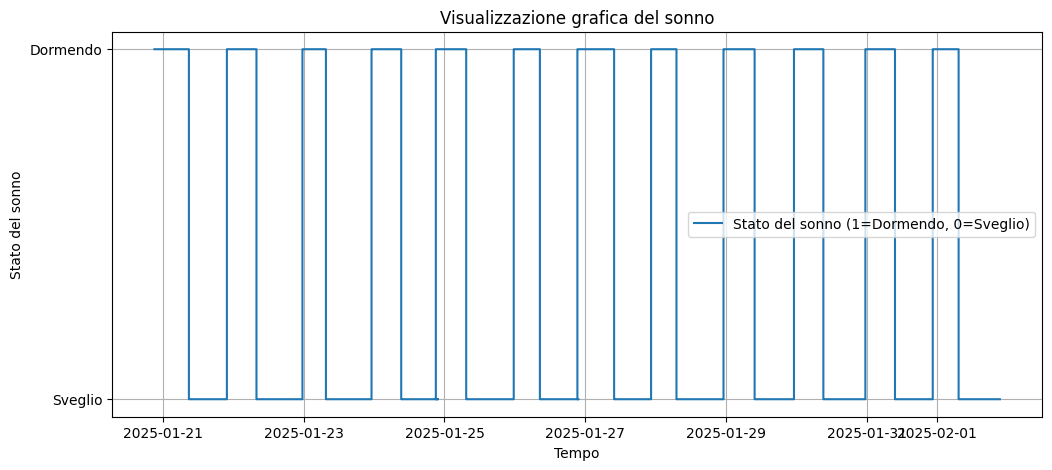

In [98]:
import matplotlib.pyplot as plt

def plot_corrected_sleep_data(df, start_time=None, end_time=None):
    df["time"] = pd.to_datetime(df["time"])

    # Filtrare il range temporale se specificato
    if start_time:
        start_time = pd.to_datetime(start_time).tz_localize("UTC", ambiguous='NaT', nonexistent='shift_forward')
        df = df[df["time"] >= start_time]

    if end_time:
        end_time = pd.to_datetime(end_time).tz_localize("UTC", ambiguous='NaT', nonexistent='shift_forward')
        df = df[df["time"] <= end_time]

    # Creare una colonna per visualizzare quando uno dorme
    df["sleeping"] = df["value"].apply(lambda x: 1 if x == 4095 else 0)


    plt.figure(figsize=(12, 5))
    plt.plot(df["time"], df["sleeping"], label="Stato del sonno (1=Dormendo, 0=Sveglio)", drawstyle="steps-post")
    plt.xlabel("Tempo")
    plt.ylabel("Stato del sonno")
    plt.title("Visualizzazione grafica del sonno")
    plt.yticks([0, 1], ["Sveglio", "Dormendo"])
    plt.legend()
    plt.grid()
    plt.show()


plot_corrected_sleep_data(simulated_df_random)

